In [3]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas

In [4]:
base_dir = os.getcwd()
data_dir = os.path.join(base_dir, 'split_dataset')
train_dir = os.path.join(data_dir, 'train')

test_realworld_dir  = os.path.join(data_dir, 'test_realworld')
test_studio_dir  = os.path.join(data_dir, 'test_studio')

In [5]:
# image preprocessing: resize and convert to tensor 
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

In [6]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


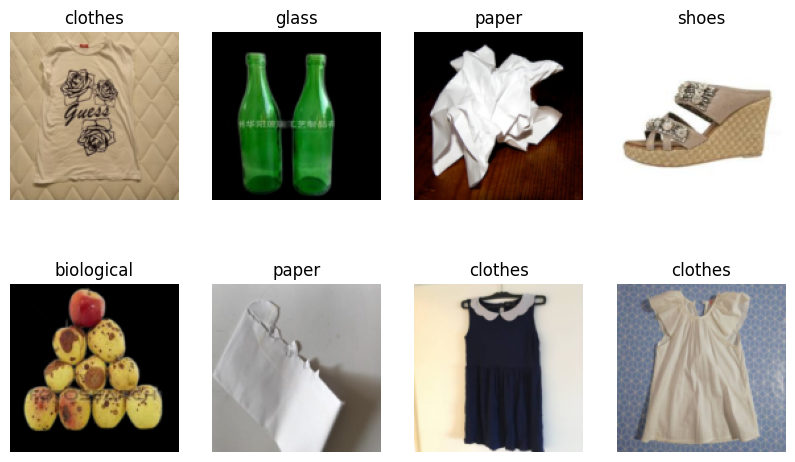

In [8]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(10, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i].permute(1, 2, 0))  # convert from C×H×W to H×W×C
    plt.title(train_dataset.classes[labels[i]])
    plt.axis("off")
plt.show()

In [9]:
class Encoder(nn.Module):
    def __init__(self,in_channels=3): #in_channels set to 3 for RGB
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, padding=1)   # (1,8,8) → (8,8,8)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)  # (8,4,4) → (16,4,4)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # conv1 + relu + pool → (8,4,4)
        x = self.pool(F.relu(self.conv2(x)))  # conv2 + relu + pool → (16,2,2)
        return x  # latent shape: (16, 2, 2)

In [10]:
class Decoder(nn.Module):
    def __init__(self,in_channels=16):
        super(Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(in_channels=in_channels, out_channels=8, kernel_size=2, stride=2)   # (16,2,2) → (8,4,4)
        self.deconv2 = nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=2, stride=2)  # (8,4,4) → (1,8,8)

    def forward(self, x):
        x = F.relu(self.deconv1(x))  # conv1 + relu + pool → (8,4,4)
        x = F.sigmoid(self.deconv2(x))  # conv2 + relu + pool → (1,8,8)
        return x

In [11]:
class ConvAutoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(ConvAutoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [12]:
num_epochs=50
lr=0.0005
batch_size=64

In [13]:
# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(in_channels=3)
decoder = Decoder()
model = ConvAutoencoder(encoder, decoder).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [14]:
#Train the model
for epoch in range(num_epochs):
    for data, _ in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

Epoch [5/50], Loss: 0.004313
Epoch [10/50], Loss: 0.003617
Epoch [15/50], Loss: 0.002483
Epoch [20/50], Loss: 0.003316
Epoch [25/50], Loss: 0.003418
Epoch [30/50], Loss: 0.002071
Epoch [35/50], Loss: 0.002577
Epoch [40/50], Loss: 0.002809
Epoch [45/50], Loss: 0.002677
Epoch [50/50], Loss: 0.002392


In [15]:
torch.save(model.encoder.state_dict(), "encoder.pth")

In [48]:
torch.save(model.state_dict(), "autoencoder.pth")

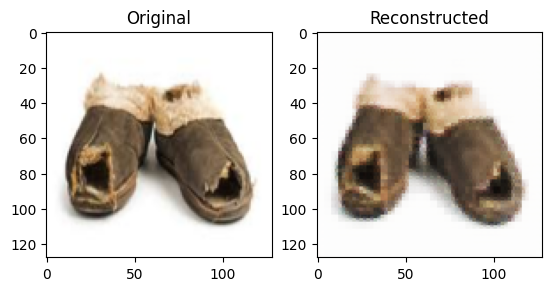

In [68]:
test_realworld_dataset = datasets.ImageFolder(root=test_realworld_dir, transform=transform)
test_realworld_loader = DataLoader(test_realworld_dataset, batch_size=32, shuffle=True)

test_studio_dataset = datasets.ImageFolder(root=test_studio_dir, transform=transform)
test_studio_loader = DataLoader(test_studio_dataset, batch_size=32, shuffle=True)

model.eval()
with torch.no_grad():
    sample_data, _ = next(iter(test_studio_loader))
    sample_data = sample_data.to(device)
    reconstructed = model(sample_data)

# Plot first image and its reconstruction
fig, axes = plt.subplots(1, 2)
axes[0].imshow(sample_data[0].cpu().permute(1,2,0))
axes[0].set_title("Original")
axes[1].imshow(reconstructed[0].cpu().permute(1,2,0))
axes[1].set_title("Reconstructed")
plt.show()